# Data Scientist Professional Practical Exam

### Company Background

Company name is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Customer Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/file.csv"`

## Business goal from company is to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.

## Import modules and set main parameters

In [1]:
import pandas as pd
import joblib
import numpy as np
from math import cos, asin, sqrt, pi
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter("ignore")
plt.rcParams['font.size'] = 14.0
sns.set(rc={'figure.figsize':(10, 7)})

# Data Validation	
## Load table from CSV file and show main info

![image](image.png)


In [2]:
df = pd.read_csv('./data/file.csv')
print(f"Detailed calculations:\nRows: {df.shape[0]}, Columns: {df.shape[1]}")
df.info()

Detailed calculations:
Rows: 8111, Columns: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


In [3]:
# Unpickle classifier once trained
try:
    rf_reg = joblib.load("./data/rf_reg.pkl")
except Exception:
    print("Model hasn't fitted yet")

## Data processing
Clean data, exclude missing values, small % types and use hot-encoding for categorial variables.

Short-term rental (stay) period is less than 30 nights: https://sfplanning.org/str/faqs-short-term-rentals

Drop all rows with **property_type** feature not at least 2% of full dataframe to prevent noise in model fitting and increase accuracy by reducing number of classes.

In [4]:
df = df.drop(columns=['id'])
df = df.dropna()
# Optimize price column as digits
df.price = pd.Series(df.price.str.replace('\..*$|[$,]', '', regex=True))

# Optimize memory and compability with few int columns
df.price = df.price.astype(int)
df.bathrooms = df.bathrooms.astype(int)
df.bedrooms = df.bedrooms.astype(int)
df.minimum_nights = df.minimum_nights.astype(int)

df = df.loc[df.minimum_nights <= 30]
df = df.reset_index(drop=True)

rows_noise_property_type = []
for i in list(set(df.property_type)):
    if len(df.loc[df.property_type == i]) < df.shape[0] // 50:
        rows_noise_property_type.append(i)

df = df.drop(index=df.loc[df.property_type.isin(rows_noise_property_type)].index)
print(f"Less than 2% property_type count: {len(rows_noise_property_type)}")

rows_noise_room_type = []
for i in list(set(df.room_type)):
    if len(df.loc[df.room_type == i]) < df.shape[0] // 50:
        # print(i, len(df.loc[df.room_type == i]))
        rows_noise_room_type.append(i)
print(f"Less than 2% room_type count: {len(rows_noise_room_type)}")

df = df.drop(index=df.loc[df.property_type.isin(rows_noise_room_type)].index)
df = df.reset_index(drop=True)
df.info()

Less than 2% property_type count: 21
Less than 2% room_type count: 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7018 entries, 0 to 7017
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        7018 non-null   float64
 1   longitude       7018 non-null   float64
 2   property_type   7018 non-null   object 
 3   room_type       7018 non-null   object 
 4   bathrooms       7018 non-null   int32  
 5   bedrooms        7018 non-null   int32  
 6   minimum_nights  7018 non-null   int32  
 7   price           7018 non-null   int32  
dtypes: float64(2), int32(4), object(2)
memory usage: 329.1+ KB


## Input data
Now you can insert input data like vector or via input()

In [5]:
#Example: [37.76605, -122.43011, 'Apartment', 'Entire home/apt', 1, 1, 10, 200]
#values_input = []
#for i in df.columns:
    #value = input(f"Value for {i} = ")
    #values_input.append(value)
#Update dataframe with input values for calculation
#df.loc[df.shape[0]] = values_input
df.loc[df.shape[0]] = [37.76605, -122.43011, 'Apartment', 'Entire home/apt', 1, 1, 10, 200]
for count, i in enumerate(df.columns):
    print(f'{str(i)}: {str(df.loc[df.shape[0]-1][count])}')

latitude: 37.76605
longitude: -122.43011
property_type: Apartment
room_type: Entire home/apt
bathrooms: 1
bedrooms: 1
minimum_nights: 10
price: 200


## Calculate distance
San Francisco coordinates: https://www.maps.ie/coordinates.html

City center coordinates: https://www.latlong.net/place/san-francisco-ca-usa-594.html

Create new feature **distance_from_center** for better correlation between input and target features, remove **latitude, longitude** features.

In [6]:
# latitude_min = df.latitude.min()
# longitude_min = df.longitude.min()
# latitude_max = df.latitude.max()
# longitude_max = df.longitude.max()

latitude_center = 37.773972
longitude_center = -122.431297

# Distance (km)
def distance(lat1, lon1, lat2, lon2):
    p = pi / 180
    distance = 12742 * asin(
        sqrt(0.5 - cos((lat2 - lat1) * p) / 2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2))
    return round(distance, 2)

try:
    df.insert(2, 'distance_from_center', '')
except ValueError:
    pass
df = df.reset_index(drop=True)
for count, i in enumerate(df.distance_from_center):
    df.loc[count, 'distance_from_center'] = distance(latitude_center, longitude_center, df.latitude[count], df.longitude[count])

df.distance_from_center = df.distance_from_center.astype(float)
df = df.drop(columns=['latitude', 'longitude'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7019 entries, 0 to 7018
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance_from_center  7019 non-null   float64
 1   property_type         7019 non-null   object 
 2   room_type             7019 non-null   object 
 3   bathrooms             7019 non-null   int64  
 4   bedrooms              7019 non-null   int64  
 5   minimum_nights        7019 non-null   int64  
 6   price                 7019 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 384.0+ KB


## Calculating stats and metrics

We use MAE and $R^2$.

In statistics, mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon.
$R^2$ - coefficient of determination.

Drop **"price"** column is for fitting model and calculating price using features from dataframe.

Encoding and scaling values as preprocessing step to make metrics better.

We also evalute our input values here.

In [7]:
def model_stat(y_test, y_pred):
    print('Output metrics:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'r2: {r2_score(y_test, y_pred)}')

X = df.drop(columns='price').copy()
y = df.price.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
# Move user data to test data to predict price for properly property accomodation
try:
    X_test.loc[df.shape[0] - 1] = X_train.loc[df.shape[0] - 1]
    y_test.loc[df.shape[0] - 1] = y_train.loc[df.shape[0] - 1]
except KeyError:
    pass
try:
    X_train = X_train.drop(df.shape[0] - 1)
    y_train = y_train.drop(df.shape[0] - 1)
except KeyError:
    pass

nume_col = list(X.select_dtypes('number').columns)
cate_col = list(X.select_dtypes('object').columns)
pipe_cate = Pipeline([('ohe', OneHotEncoder(sparse=False, drop=None))])
pipe_nume = Pipeline([('scaler', StandardScaler())])
preprocessor = ColumnTransformer([('nume_feat', pipe_nume, nume_col),
                                  ('cate_feat', pipe_cate, cate_col)])
X_train_pr = pd.DataFrame(preprocessor.fit_transform(X_train),
                          columns=nume_col + list(preprocessor.named_transformers_['cate_feat'].
                                       named_steps['ohe'].get_feature_names_out(cate_col)))
X_test_pr = pd.DataFrame(preprocessor.transform(X_test),
                         columns=nume_col + list(preprocessor.named_transformers_['cate_feat'].
                                      named_steps['ohe'].get_feature_names_out(cate_col)))

# Model Fitting
## Model based on regressor since price calculation is a regression task and it is suitable to use one of SOTA regressors.

**Random Forest** is selected and fitted due to high accuracy and calculations: https://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf

We use **RandomizedSearchCV** to get optimal set of parameters based on feedback from regressor.

In [8]:
# Improve metrics
# n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=2)]
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 20, num=3)]
# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth
#                }

# Tuning hyperparameters
# rf = RandomForestRegressor(criterion='absolute_error',
#                            max_features='sqrt',
#                            min_samples_split=2,
#                            min_samples_leaf=1, )
# rf_random = RandomizedSearchCV(estimator=rf,
#                                param_distributions=random_grid,
#                                n_iter=6,
#                                cv=5,
#                                verbose=2,
#                                scoring='neg_mean_absolute_error',
#                                random_state=42,
#                                n_jobs=-1)

# Fit the random search model
# rf_random.fit(X_train_pr, y_train)
# print(rf_random.best_params_)
# Output:
# {'n_estimators': [100, 200], 'max_depth': [10, 15, 20]}
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# {'n_estimators': 200, 'max_depth': 10}

# Optimal parametres from RandomizedSearchCV
# rf_reg = RandomForestRegressor(n_estimators=200,
#                                criterion='absolute_error',
#                                min_samples_split=2,
#                                min_samples_leaf=1,
#                                max_features='sqrt',
#                                max_depth=10,
#                                bootstrap=False,
#                                n_jobs=-1)
# rf_reg.fit(X_train_pr, y_train)

# Model Evaluation
## Inference (once the model was fitted)

Exporting model via Pickle. Once trained we can use it to increase performance and get same results.

Feature importances show as what feature is used by regressor less or more.

Output metrics:
MAE: 61.39567259786478
r2: 0.48617503047862276


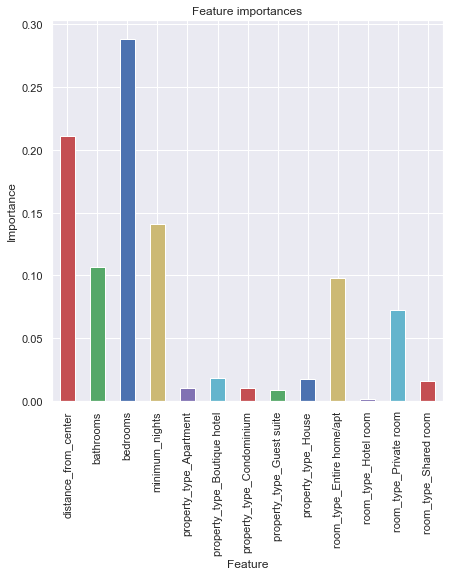

Feature importances: [0.21116199 0.10672466 0.28878906 0.1406982  0.01058014 0.01797146
 0.01000947 0.00904596 0.01710215 0.09770609 0.00136376 0.07267685
 0.01617022]
Sum: 1.0


In [9]:
y_pred_rf = rf_reg.predict(X_test_pr)
model_stat(y_test, y_pred_rf)

# Feature importance
features_value = pd.DataFrame({'features': rf_reg.feature_importances_, 'value': X_train_pr.columns})
features_value.plot(kind='bar', x='value', y='features', figsize=(7, 7), color=list('rgbymc'), legend=False)
plt.title('Feature importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

print(f'Feature importances: {rf_reg.feature_importances_}')
print(f'Sum: {rf_reg.feature_importances_.sum()}')

# Export model as pkl file if needed
#joblib.dump(rf_reg, "./data/rf_reg.pkl")

# Data Visualization, Communication
## Visualization output results and metrics for customer question
## Business Focus and comparision to the business success criteria

If the **calculated_price** is higher that **price** that user input more that 25$ it means, that estimated accomodation price per night is more expensive for more than 25 dollars of actual price.

If the **price** is higher that **calculated_price** that user input more that 25$ it means, that estimated accomodation price per night is more cheaper for more than 25 dollars of actual price.

Otherwise, Estimated accomodation price per night is in a range of 25 dollars from an actual price that suitable for company online platform business success criteria.

In [10]:
calculated_price = y_pred_rf[y_pred_rf.shape[0] - 1]
print(f'Calculated price: {calculated_price}')
price = df.loc[df.shape[0]-1].price
if calculated_price - price > 25:
    print(f'Estimated rental price per night is more expensive for more than 25 dollars of actual price ~ {round(calculated_price-price, 1)}$ or ~ {round(((abs(calculated_price-price))/price)*100,1)}%')
elif price - calculated_price > 25:
    print(f'Estimated rental price per night is more cheaper for more than 25 dollars of actual price ~ {round(price-calculated_price, 1)}$ or ~ {round(((abs(calculated_price-price))/calculated_price)*100,1)}%')
else:
    print(f'Estimated rental price per night is in a range of 25 dollars from an actual price and the difference is ~ {round(abs(calculated_price-price), 1)}')

Calculated price: 174.7525
Estimated rental price per night is more cheaper for more than 25 dollars of actual price ~ 25.2$ or ~ 14.4%


## Business Metrics

Pearson matrix to understand correlation between features with target feature for example.

The higher Pearson coefficient is, the stronger correlation between column's pair.

"-1" means reversed correlation, for example, when x-> inf, y-> - inf, "1" means direct correlation, for example, when x-> inf, y-> inf.

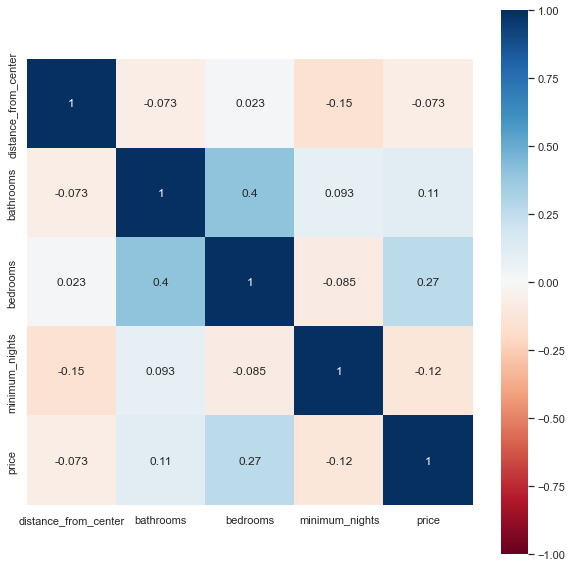

In [11]:
df_visualization = df[
['distance_from_center', 'property_type', 'room_type', 'bathrooms', 'bedrooms', 'minimum_nights', 'price']]

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdBu', square=True)
plt.show()

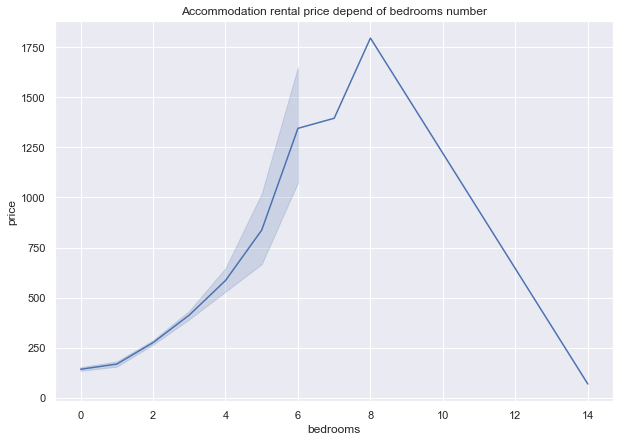

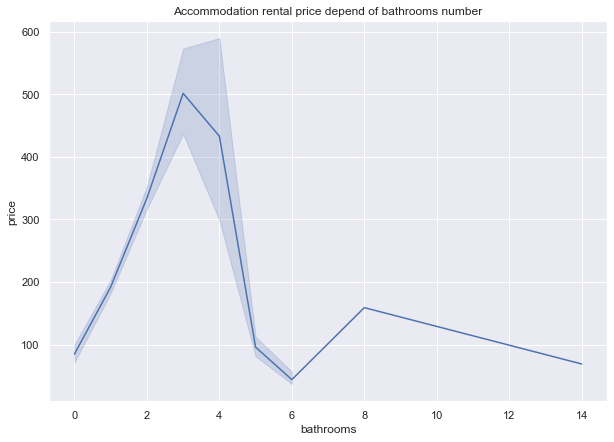

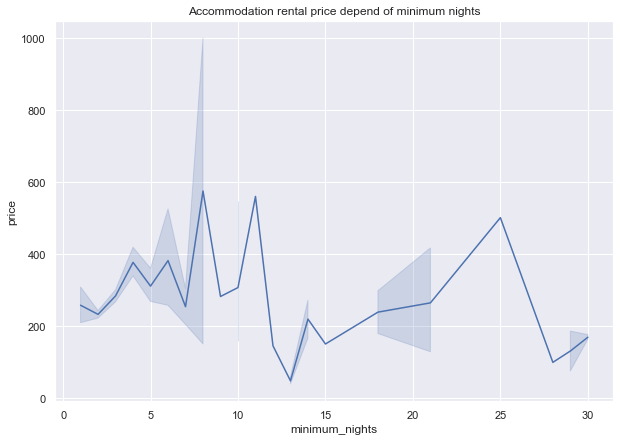

In [12]:
# More output results for presentation
sns.lineplot(data=df, x="bedrooms", y="price")
plt.title("Accommodation rental price depend of bedrooms number")
plt.show()

sns.lineplot(data=df, x="bathrooms", y="price")
plt.title("Accommodation rental price depend of bathrooms number")
plt.show()

sns.lineplot(data=df, x="minimum_nights", y="price")
plt.title("Accommodation rental price depend of minimum nights")
plt.show()

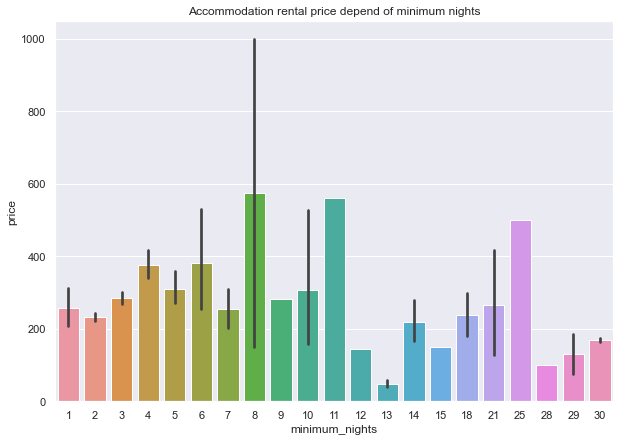

In [13]:
sns.barplot(x='minimum_nights', y='price', data=df)
plt.xlabel("minimum_nights")
plt.ylabel("price")
plt.title("Accommodation rental price depend of minimum nights")
plt.show()

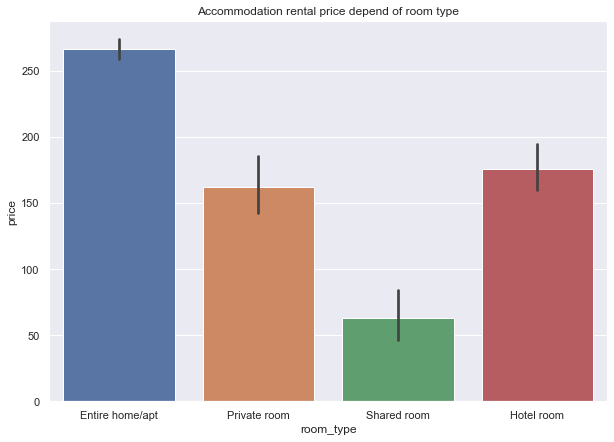

In [14]:
sns.barplot(x='room_type', y='price', data=df)
plt.xlabel("room_type")
plt.ylabel("price")
plt.title("Accommodation rental price depend of room type")
plt.show()

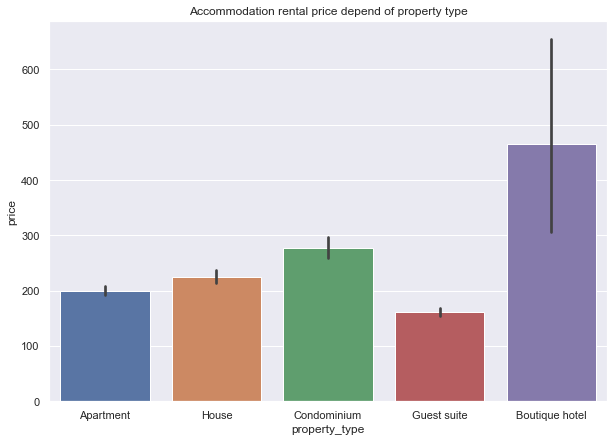

In [15]:
sns.barplot(x='property_type', y='price', data=df)
plt.xlabel("property_type")
plt.ylabel("price")
plt.title("Accommodation rental price depend of property type")
plt.show()

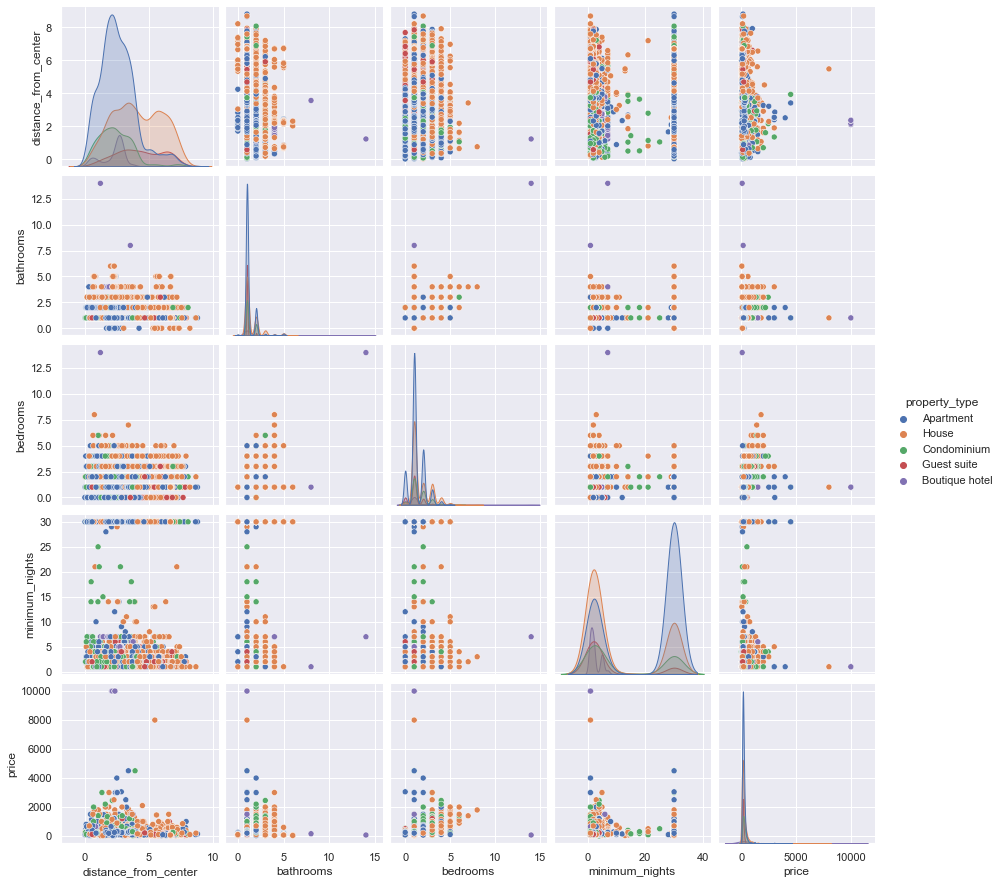

In [16]:
sns.pairplot(df_visualization, hue="property_type")
plt.show()

In [ ]:
sns.pairplot(df_visualization, hue="room_type")
plt.show()

# Insights (findings)
1) The greatest absolute target feature correlated with the “bedrooms” feature;

2) Accommodation rental prices for less that a week more often have more expensive price;

3) Count of bedrooms and bathrooms increase the price for some amount and then during the changing type of room or property the rental price can be lower.

# Conclusion
Current work has addressed the business problem of company since now it is possible to calculate price in a real time and get feedback of typical user expectations based on his input accommodation rental price.

We used RandomForest regressor as our model and serialize it via Pickle to make it stable and possible for next inference and deployment.

Presented output metrics and visualizations.

Make a GUI version via Streamlit (in presentation).

## If you are looking for cheap accommodation price per night:
1) Take more than a week rental;
2) Prefer accommodation not in city center;
3) Live in shared room in a guest suite.
## If you can pay expensive price per night for accommodation:
1) Live in entire home/apt in a guest suite in boutique hotel;
2) Choose accommodation in a city center.

## Main recommendations for future work that the business should undertake to avoid estimating prices that are more than 25 dollars off of the actual price.

Since that in can be done mainly with adding more parameters to accurate the recommendations are to collect features like:
1. Season (or month) cause it can be more expensive in cold seasons (like winters) if you pay utility bill by your own.
2. Square meters of your accommodation.